In [98]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from csv_data import get_vocab_dict
from csv_data import get_all_articles
from csv_data import csv_list_to_list
from csv_data import split_data
from csv_data import check_duplicates


ordered_dict = get_vocab_dict()
data_total, labels_total = get_all_articles(shuffle=True)
nationalities = csv_list_to_list('resources/nationalities.csv')
countries = csv_list_to_list('resources/countries.csv')
ignore_list = csv_list_to_list('resources/ignore_list.csv')

check_duplicates(data_total)

train_data, val_data, train_labels, val_labels = split_data((data_total, labels_total), 5)

print("Train data/labels length: ", len(train_data), len(train_labels))
print("Validation data/labels length: ", len(val_data),  len(val_labels))


Train data/labels length:  9063 9063
Validation data/labels length:  476 476


In [100]:
import re

for i,tt in enumerate(data_total):
    if re.search(r'målfest', tt, re.IGNORECASE):
        # if (labels_total[i] == 0):
            print(tt)
            print(labels_total[i])
        # print(train)



håndbold  . danske stjerner holder iøjnefaldende målfest i bundesligaen  . fem ud af de seks højest rangerede spillere på bundesligaens topscorerliste kommer fra danmark
1
uefa em 2020  . braithwaite lukkede ballet i dansk målfest: 'vi er vikinger, og vi er der for at erobre'  . martin braithwaite scorede til 4-0 i ottendedelsfinalen ved em mod wales
1
ishockey . aalborg pirates overvinder stærk odense-start i målfest . odense bulldogs var foran 3-1, men tabte 5-8 til aalborg pirates i et festligt opgør i metal ligaen
1
ishockey . landstræners opsang satte gang i målfest . efter en sløj start kom der liv i det danske ishockeylandshold, der lavede syv mål i 2. periode
1
fodbold . chelsea og manchester city deler efter dramatisk målfest . en vanvittig målfest endte i uafgjort, da chelsea og manchester city spillede 4-4 på stamford bridge
1
fodbold . sprudlende real madrid holder målfest . for første gang i denne sæson scorede real madrid fem mål i en kamp
1
vm fodbold . vanvittige comeba

In [101]:
counts = np.bincount(train_labels)

print(counts)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}

[5064 3999]


In [102]:
import time
isin_dict = False
def test_lookup_performance():
    word_to_check = "rune"
    start_time = time.time()

    for x in range(1000000):
        isin_dict = word_to_check in ordered_dict

    end_time = time.time()  
    assert(end_time - start_time < 1)
    print(isin_dict)

test_lookup_performance()

# isin_dict


False


In [103]:
from create_vocab import remove_duplicates
from create_vocab import remove_nationalities
from create_vocab import remove_non_frequent
from utils import remove_words_containing_digits
from create_vocab import remove_non_dict_words
from vectorization import to_lower
from vectorization import remove_dash
from vectorization import split_included_specials
from vectorization import standardize
from vectorization import regex_dict


def train_text_to_formatted_words(sentences):

    def custom_standardization(input_data): 
        x = tf.strings.regex_replace(input_data, pattern=regex_dict["remove_special_chars"]["regex"], rewrite=regex_dict["remove_special_chars"]["replacewith"])
        x = tf.strings.regex_replace(x, pattern=regex_dict["replace_quotation"]["regex"], rewrite=regex_dict["replace_quotation"]["replacewith"])
        x = tf.strings.regex_replace(x, pattern=regex_dict["split_by_specials"]["regex"], rewrite=regex_dict["split_by_specials"]["replacewith"])
        return x

    words_formatted = []
    for sentence in sentences:
        words = custom_standardization(sentence).numpy().decode().split()
        words_formatted.extend(words)

    return words_formatted

words_formatted = train_text_to_formatted_words(train_data)

sentence_words_frequent = remove_non_frequent(words_formatted, 1)
words_arr_unique = remove_duplicates(sentence_words_frequent)
words_arr_unique = remove_words_containing_digits(words_arr_unique)
    
words_train_vocab, words_sport_lingo = remove_non_dict_words(words_arr_unique, ordered_dict)


print("total sports lingo words:", len(words_sport_lingo) )
print("total vocab:", len(words_train_vocab))



total sports lingo words: 2323
total vocab: 7446


In [104]:

"håndbold" in words_train_vocab

True

In [105]:
file = open('words_sport_lingo.txt','w')
for item in words_sport_lingo:
	file.write(item+"\n")
file.close()

file = open('words_train_vocab.txt','w')
for item in sorted(words_train_vocab):
	file.write(item+"\n")
file.close()


In [106]:


for f in remove_duplicates(words_formatted):
    if f in words_sport_lingo and f not in ignore_list and len(f) > 1:
        print(f)


danskerdag
danskerholdet
herfølge
cadiz
nicoline
havertz
johnsons
brøgger
danskerduel
venables
leonard
ståle
danskermål
terry
hummel
grækenlands
matterhorn
borgnæs
danskerfinale
mæhles
gladsaxe
nordjylland
danskerbil
giant
pokalkvartfinalen
danskerbrag
danskerhold
søe
fraisl
ringkøbing


In [107]:


from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from vectorization import vect_layer_2_text
from vectorization import vectorize_layer
from vectorization import standardize
from vectorization import custom_standardization
from static_data import tournaments
from static_data import weekdays
from static_data import non_alpha
from static_data import word_generalization

words_train_vocab.extend(word_generalization)
words_train_vocab.extend(non_alpha)

max_features = 7500
sequence_length = 60

vectorize = vectorize_layer(max_features, sequence_length, custom_standardization)

vectorize.adapt(words_train_vocab)
vectorization_vocab = vectorize.get_vocabulary()

# print("Total vocab/max_features : ",  len(vectorization_vocab))
# #
# print (vect_layer_2_text(vectorize(['rusland (frataget) vm . det internationale ishockeyforbund (iihf) har besluttet, at "rusland" ikke kan være vm-vært næste år']), vectorization_vocab))



In [108]:
import json

from vectorization import regex_dict

with open('vocab.json', 'w',  encoding='utf8') as file:
    json.dump(vectorization_vocab, file, ensure_ascii=False)

with open('regexes.json', 'w',  encoding='utf8') as file:
    json.dump(regex_dict, file, ensure_ascii=False)



In [109]:
train_data_vect = vectorize(train_data)
val_data_vect = vectorize(val_data)


In [110]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
        })
        return config

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
        })
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions



In [111]:
from tensorflow.keras import layers
import random as python_random

def get_cnn_model():

   embed_dim =  92 # Embedding size for each token
   inputs = tf.keras.Input(shape=(None,), dtype="int64")

   x = layers.Embedding(max_features, embed_dim)(inputs)
   x = layers.Dropout(0.5)(x)

   x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
   x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
   x = layers.GlobalMaxPooling1D()(x)

   x = layers.Dense(128, activation="relu")(x)
   x = layers.Dropout(0.5)(x)

   predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
    
   cnn_model = tf.keras.Model(inputs, predictions)

   cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
   return cnn_model



In [112]:
from tensorflow.keras import layers
import random as python_random
from tensorflow.keras.models import Sequential


def get_simple_model():

    embed_dim =  92 # Embedding size for each token

    input_dim = train_data_vect.shape[1]

    model = Sequential()
    model.add(layers.Dense(500, input_dim=input_dim, activation='sigmoid', name="L1"))
    model.add(layers.Dense(500, activation='sigmoid', name="L2"))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
    return model


In [113]:
from tensorflow.keras import layers
import random as python_random


def get_transformer_model():

    embed_dim =  192 # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 192  # Hidden layer size in feed forward network inside transformer

    inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64")
    embedding_layer = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)
    x = embedding_layer(inputs)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.Dropout(0.1)(x)
    x = layers.GlobalMaxPooling1D()(x)

    predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

    transformer_model = tf.keras.Model(inputs, predictions)
    
    transformer_model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
    return transformer_model


In [114]:

def prepare_model(name):
    if (name == "simple"):
       return get_simple_model()
    elif (name == "transformer"):
       return get_transformer_model()
    # elif (name == "simple"):
    #    return get_simple_model()
  

def filter_max_accuracy(history, threshold = 0.95):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    list = []
    for x in range(len(acc)):
        if (acc[x] > threshold):
            list.append(val_acc[x])

    return np.array(list)

models = ["simple", "transformer"]

callback_3_loss = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)


def mean_model_accuracy(mode_names, iterations, epochs = 6):

  
    results = []

    for name in range(len(mode_names)):
        model_name = mode_names[name]
        val_accuracies = []
        
        for x in range(iterations):
            model = prepare_model(model_name)

            # Fit the model using the train and test datasets.
            history = model.fit(train_data_vect, train_labels, epochs=epochs, batch_size=60, validation_data=(val_data_vect, val_labels), callbacks=[callback_3_loss], class_weight=class_weight)

            max_val_acc = filter_max_accuracy(history)
            val_accuracies.append(max(max_val_acc))
            print(max(max_val_acc))
            print(val_accuracies)
        
        d = dict(name = model_name, results = np.mean(np.squeeze(np.array(val_accuracies))))
        results.append(d)
        
    return results


In [115]:
# mean_results = mean_model_accuracy(models, 5)
# mean_results

In [116]:
def result_format_round(result):
    return round(result)

def result_format_none(result):
    return result

def print_model_score(model):
    score = model.evaluate(val_data_vect, val_labels, verbose=0)
    print("Validation loss:", score[0])
    print("Validations accuracy:", score[1])

def print_validation_results(predictions, val_data, labels, formatter, only_incorrect = False):
    print("Number of predictions", len(predictions))
    n_correct = 0
    for x in range(len(val_data)):
        correct_prediction = result_format_round(labels[x]) == result_format_round(predictions[x][0])
        if correct_prediction:
            n_correct += 1

        if correct_prediction == False:
            print("VALIDATION SAMPLE TEXT: \n" ,val_data[x])
            print("VALIDATION SAMPLE DE-VECTORIZED: \n" ,vect_layer_2_text(val_data_vect[x], vectorization_vocab))
            print("LABEL -- :" , labels[x])
            print("PREDICTION -- :" , formatter(predictions[x][0]), " ---- float: ", predictions[x][0])
            print("CORRECT PREDICTION: ", correct_prediction)
            print("\n")

    print("Number correct: ", n_correct)

In [117]:

# epochs= 10
# simple_model = get_simple_model()

# simple_model_history = simple_model.fit(train_data_vect, train_labels, epochs=epochs, batch_size=60, validation_data=(val_data_vect, val_labels),  class_weight=class_weight,)

In [118]:

epochs= 5
transformer_model = get_transformer_model()

transformer_history = transformer_model.fit(train_data_vect, train_labels, epochs=epochs, batch_size=60, validation_data=(val_data_vect, val_labels),  class_weight=class_weight,)


Epoch 1/5
152/152 [==============================] - 4s 19ms/step - loss: 1.1381e-04 - accuracy: 0.7336 - val_loss: 0.3315 - val_accuracy: 0.8655
Epoch 2/5
152/152 [==============================] - 2s 16ms/step - loss: 5.7502e-05 - accuracy: 0.8954 - val_loss: 0.2452 - val_accuracy: 0.8803
Epoch 3/5
152/152 [==============================] - 2s 16ms/step - loss: 3.2295e-05 - accuracy: 0.9479 - val_loss: 0.2263 - val_accuracy: 0.8950
Epoch 4/5
152/152 [==============================] - 2s 16ms/step - loss: 1.6915e-05 - accuracy: 0.9772 - val_loss: 0.2173 - val_accuracy: 0.9076
Epoch 5/5
152/152 [==============================] - 2s 16ms/step - loss: 9.5008e-06 - accuracy: 0.9900 - val_loss: 0.2227 - val_accuracy: 0.9076


In [119]:
transformer_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
token_and_position_embedding (None, 60, 192)           1451520   
_________________________________________________________________
transformer_block_2 (Transfo (None, 60, 192)           371136    
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 192)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 192)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 193       
Total params: 1,822,849
Trainable params: 1,822,849
Non-trainable params: 0
_________________________________________________

In [120]:
# np.set_printoptions(suppress=True)
# epochs= 5
# cnn_model = get_cnn_model()

# cnn_history = cnn_model.fit(train_data_vect, train_labels, epochs=epochs, batch_size=30, validation_data=(val_data_vect, val_labels))

In [121]:
# print(cnn_history.history.keys())

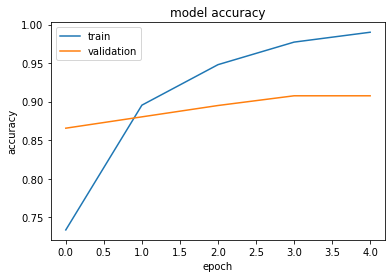

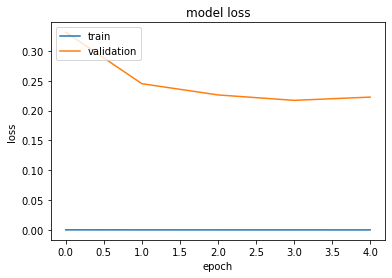

In [122]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(transformer_history.history['accuracy'])
plt.plot(transformer_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(transformer_history.history['loss'])
plt.plot(transformer_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [123]:
# cnn_model.summary()
print(0.00001357)

1.357e-05


In [124]:
def print_results(model):
    np.set_printoptions(precision = 5, suppress = True)
    predictions = model.predict(val_data_vect)
    print_model_score(model)
    print("\n")
    print_validation_results(predictions, val_data, val_labels, result_format_round)
  

In [125]:
predictions = transformer_model.predict(val_data_vect[0:1])
val_data_vect[0]

len(predictions)

predictions

array([[0.99843]], dtype=float32)

In [126]:
print("--- TRANSFORMER ---")
print_results(transformer_model)

--- TRANSFORMER ---
Validation loss: 0.2226935178041458
Validations accuracy: 0.9075630307197571


Number of predictions 476
VALIDATION SAMPLE TEXT: 
 fodbold . så vild er forskellen på danmark og san marino . san marino har vundet én fodboldkamp i nationens historie
VALIDATION SAMPLE DE-VECTORIZED: 
 ['fodbold' 'så' 'vild' 'er' 'forskellen' 'på' 'xland' 'og' 'xland' 'xland'
 'har' 'vundet' 'én' 'fodboldkamp' 'i' 'nationens' 'historie']
LABEL -- : 0
PREDICTION -- : 1  ---- float:  0.9888095
CORRECT PREDICTION:  False


VALIDATION SAMPLE TEXT: 
 baseball  . ups: her lander faldskærmsudspringer på baseballspiller . det skulle være så flot, men endte så kluntet
VALIDATION SAMPLE DE-VECTORIZED: 
 ['baseball' '[UNK]' 'her' 'lander' '[UNK]' 'på' 'baseballspiller' 'det'
 'skulle' 'være' 'så' 'flot' 'men' 'endte' 'så' '[UNK]']
LABEL -- : 0
PREDICTION -- : 1  ---- float:  0.561436
CORRECT PREDICTION:  False


VALIDATION SAMPLE TEXT: 
 atletik  . video kenyaner øjner copenhagen half-sejr  . den 

In [127]:

# print("--- CNN ---")
# print_results(cnn_model)

In [128]:
import os

# Set up a logs directory, so Tensorboard knows where to look for files.

ll = transformer_model.layers[1]
ll_weights = ll.get_weights()[0]

# print(ll_weights.shape)
ll_weights


array([[-0.00275, -0.02986, -0.0008 , ...,  0.01634, -0.04512,  0.02406],
       [ 0.0032 , -0.02306,  0.0125 , ...,  0.02589,  0.04028,  0.03124],
       [-0.00654, -0.02477,  0.01039, ...,  0.05118,  0.02864,  0.02305],
       ...,
       [-0.0484 , -0.00234, -0.03886, ..., -0.01905,  0.02667, -0.03213],
       [ 0.00181,  0.03179,  0.00414, ...,  0.00937, -0.0291 ,  0.00243],
       [-0.00923, -0.02904,  0.0466 , ..., -0.04272, -0.03054, -0.02245]],
      dtype=float32)

In [129]:
##import I/O module in python
import io

##open the text stream for vectors
vectors = io.open('vectors.tsv', 'w', encoding='utf-8')

##open the text stream for metadata
meta = io.open('meta.tsv', 'w', encoding='utf-8')


##write each word and its corresponding embedding
for index in range(1, len(vectorization_vocab)):
  word = vectorization_vocab[index]  # flipping the key-value in word_index
  embeddings = ll_weights[index]
  meta.write(word + "\n")
  vectors.write('\t'.join([str(x) for x in embeddings]) + "\n")

##close the stream
vectors.close()
meta.close()

In [130]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices

indices = vectorize(inputs)
# Turn vocab indices into predictions
outputs = transformer_model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)


In [131]:
print("\nResults:")


print(end_to_end_model.predict(
    [
      "Fodbold . Fjerritslev vinder over Vordingborg. Træner kommenterer på historisk kamp",
       "SPORT . Hun vandt bronze i mandags Roer Anne Dsane Andersen har som 24-årig vundet bronze ved OL",
       "Badminton . Axelsen frustreret over nederlag. Viktor Axelsen trænger til ferie efter nedturen",
      "OL . Det blev til en flot medalje til Malene dfhsds. 'Jeg er meget lykkelig for resultatet'",
      "Badminton . Dansker er videre til finalerne. dsfsdf sfdsdf bankede Fdfsdf fra Kina og skal spille i finalen på onsdag",
      "Badminton . Dansker er videre til finalerne. dsfsdf sfdsdf skal spille i finalen på onsdag",
     ]))


print("\n NON-Results:") 
print(end_to_end_model.predict(
    [
      "OL Meget skal ske før en medalje kommer inden for rækkevidde. Dressurrytter Malene dsds har mistet troen på success",
      "Fodbold . Træner for Fjerritslev ser frem til sejr over Vordingborg. 'Det bliver en historisk kamp'",
      "Fodbold . De danske spillere skal op imod Sverige, som de tabte til i 2022",
      "Fodbold . De danske spillere vil forsøge at besejre Tyrkiet den kommende Lørdag i VM-kamp. Tyrkiet har aldriv været i en VM-finale",
      "Fodbold . De danske spillere tror på sejr mod Tyrkiet. 'Den skal vindes'",
      "Skisport . Sverige drømmer om flere medaljer og sejre til næste års OL . Træner forventer flere gode resultater",
      "Boksning . Kesler vil overraske alle og gøre det umulige. 'Jeg vinder i VM'",
      "Boksning . Kesler med stor selvtillid: 'Det bliver guld eller sølv til VM'"
     ]))


Results:
[[0.98413]
 [0.99832]
 [0.99999]
 [0.97632]
 [0.96432]
 [0.64979]]

 NON-Results:
[[0.00101]
 [0.434  ]
 [0.821  ]
 [0.01429]
 [0.09012]
 [0.07364]
 [0.24086]
 [0.96513]]


In [132]:
print("\n IN-BETWEEN-Results:") 
print(end_to_end_model.predict(
    [
       "Fodbold . Fjerritslev vandt i lørdags over Vordingborg 1-0. Den danske anfører dasdad dasdasd triumferer",
       "Fodbold . Fjerritslev vandt i lørdags over Vordingborg. Den danske anfører adasdasdd daddas triumferer",
       "Fodbold . Fjerritslev vandt i lørdags over Vordingborg. Efter kampen meddelyte den danske anfører sdfd sdfdf, at han skal under kniven",
       "Fodbold . Superliga-profil efter storsejr over Vordingborg. ' Den danske anfører fsdsdff sdffsd skal opereres og er ude i flere måneder",
       "Fodbold . Superliga-profil har meddelelse efter sejr. Den danske anfører fdfd sdffdf skal opereres og er ude i flere måneder",
       "Fodbold . Superliga-profil kan se frem til en længere pause. Den danske anfører fdfd sdfff skal opereres og er ude i flere måneder"
       
        ]))


 IN-BETWEEN-Results:
[[0.99999]
 [0.99998]
 [0.79517]
 [0.2384 ]
 [0.49494]
 [0.00366]]


In [133]:
# end_to_end_model.save('end_to_end_model')
# loaded_model = keras.models.load_model('end_to_end_model')

In [134]:
# import tensorflowjs as tfjs

# tfjs

In [135]:
# !pip install tensorflowjs
# !tensorflowjs_converter --input_format keras "cnn_emnist.h5" ./jsmodel